## Second version for the EWC Notebook

The idea is to try to start from scratch and adapt the code to the data. 

We will for instance try:
- Velocity as a target
- Not normalizing the target
- Start with basic model and add layers if I see it improves
- Do not check outliers here

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
date = '0504'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path = './Data/Processed_Data/Tidy_Sansa_0504Clean.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [9]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [10]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

## Get train-val-test split

In [11]:
fold = 0

In [12]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= 'target_vel', no_outliers = False)

Test trials  6
Val trials 4
We are testing the optimization method on fold  0


In [13]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim,\
      xx_test_stim, yy_test_stim, info_train_stim, info_val_stim,\
          info_test_stim,  list_mins_stim, \
            list_maxs_stim = get_dataset(tonic_df, fold, target_variable= 'target_vel', no_outliers = False)

Test trials  7
Val trials 6
We are testing the optimization method on fold  0


In [14]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all, \
    xx_test_all, yy_test_all, info_train_all, \
    info_val_all, info_test_all,  list_mins_all,\
          list_maxs_all = get_dataset(tidy_df,fold, target_variable= 'target_vel', no_outliers = False)

Test trials  26
Val trials 21
We are testing the optimization method on fold  0


In [15]:
# Specify that we want our tensors on the GPU and in float32
#device = torch.device('cuda:0') #suposed to be cuda
device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [16]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Baseline Model

In [17]:
class Model(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                input_size = 50,
                out_dims = 6,):
        super(Model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size
        self.out_dims = out_dims

        self.rnn = nn.RNN(
            input_size = self.num_features, 
            hidden_size = self.hidden_units, 
            num_layers = self.num_layers, 
            nonlinearity='tanh', bias= True, 
            batch_first= True, dropout=0.0, 
            bidirectional=False,)
        
        self.selu = nn.SELU()

        self.linear = nn.Linear(in_features=self.hidden_units, out_features= self.out_dims)
        
        # Flatten the parameters
        self.rnn.flatten_parameters()

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.selu(x) 
        output = self.linear(x)
        
        return output.squeeze()

In [18]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1

l1_ratio_reg = 0.5

lr = 0.0001# 0.0002
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 150
num_layers = 2
input_size_LSTM = 31
dropout_1 = 0.2
dropout_2 = 0.2

#Other training hyperparameters

lr_gamma= 0.9 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 15
batch_size_val = 15

In [19]:
# Fit the LSTM model
model_base = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                input_size = input_size_LSTM,
                out_dims = num_dim_output).to(device)

model_base.apply(weight_reset)

Model(
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=150, out_features=3, bias=True)
)

In [20]:
train_losses, val_losses = \
    train_model(model_base, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=Regularizer_RNN,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

Epoch 000 Train 1295.3301 Val 1378.0190
Epoch 001 Train 1284.3390 Val 1371.0324
Epoch 002 Train 1277.8000 Val 1365.0115
Epoch 003 Train 1272.1183 Val 1359.9650
Epoch 004 Train 1266.8934 Val 1354.6943
Epoch 005 Train 1261.9150 Val 1349.7615
Epoch 006 Train 1257.2635 Val 1345.3498
Epoch 007 Train 1252.6185 Val 1340.9764
Epoch 008 Train 1248.0750 Val 1336.7256
Epoch 009 Train 1243.5957 Val 1332.6550
Epoch 010 Train 1239.4602 Val 1329.0594
Epoch 011 Train 1235.2347 Val 1325.3798
Epoch 012 Train 1230.2557 Val 1322.0215
Epoch 013 Train 1225.0985 Val 1318.1728
Epoch 014 Train 1219.9190 Val 1314.2330
Epoch 015 Train 1215.0183 Val 1311.1150
Epoch 016 Train 1210.6082 Val 1308.4690
Epoch 017 Train 1206.4783 Val 1304.4436
Epoch 018 Train 1202.2379 Val 1300.0010
Epoch 019 Train 1198.2322 Val 1295.6377
Epoch 020 Train 1194.5329 Val 1292.3977
Epoch 021 Train 1191.1984 Val 1289.5169
Epoch 022 Train 1187.6294 Val 1287.2700
Epoch 023 Train 1184.2057 Val 1284.7732
Epoch 024 Train 1180.7550 Val 1281.3878


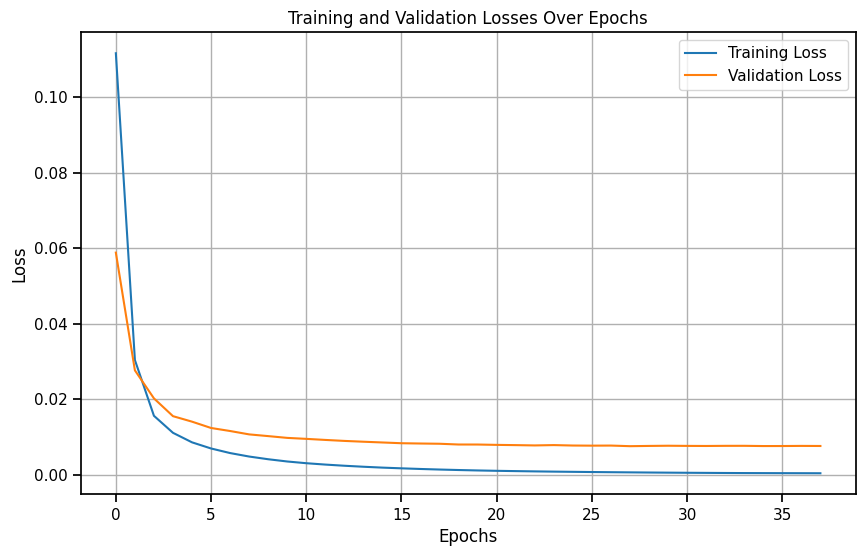

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Baseline'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_base, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [ ]:
""" model_baselineonly = torch.load(path_to_save_model_fold)
model_baselineonly.eval() """

' model_baselineonly = torch.load(path_to_save_model_fold)\nmodel_baselineonly.eval() '

In [ ]:
def reshape_to_eval(x,y, model):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_val, y_true_val,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test
    
    elif metric == 'r2':
        #Compute explained variance
        ev_train = r2_score(y_true_train, y_pred_train)
        ev_val = r2_score(y_true_val, y_pred_val)
        ev_test = r2_score(y_true_test, y_pred_test)
        print('Train R2: %.2f ' % (ev_train))
        print('Val R2: %.2f ' % (ev_val))
        print('Test R2: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base, metric = 'ev')

Train EV: 0.84 
Val EV: 0.04 
Test EV: 0.00 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base, metric = 'r2')

Train R2: 0.84 
Val R2: 0.03 
Test R2: -0.00 


In [ ]:
y_true_train, y_pred_train = reshape_to_eval(xx_train_base,yy_train_base, model_base)

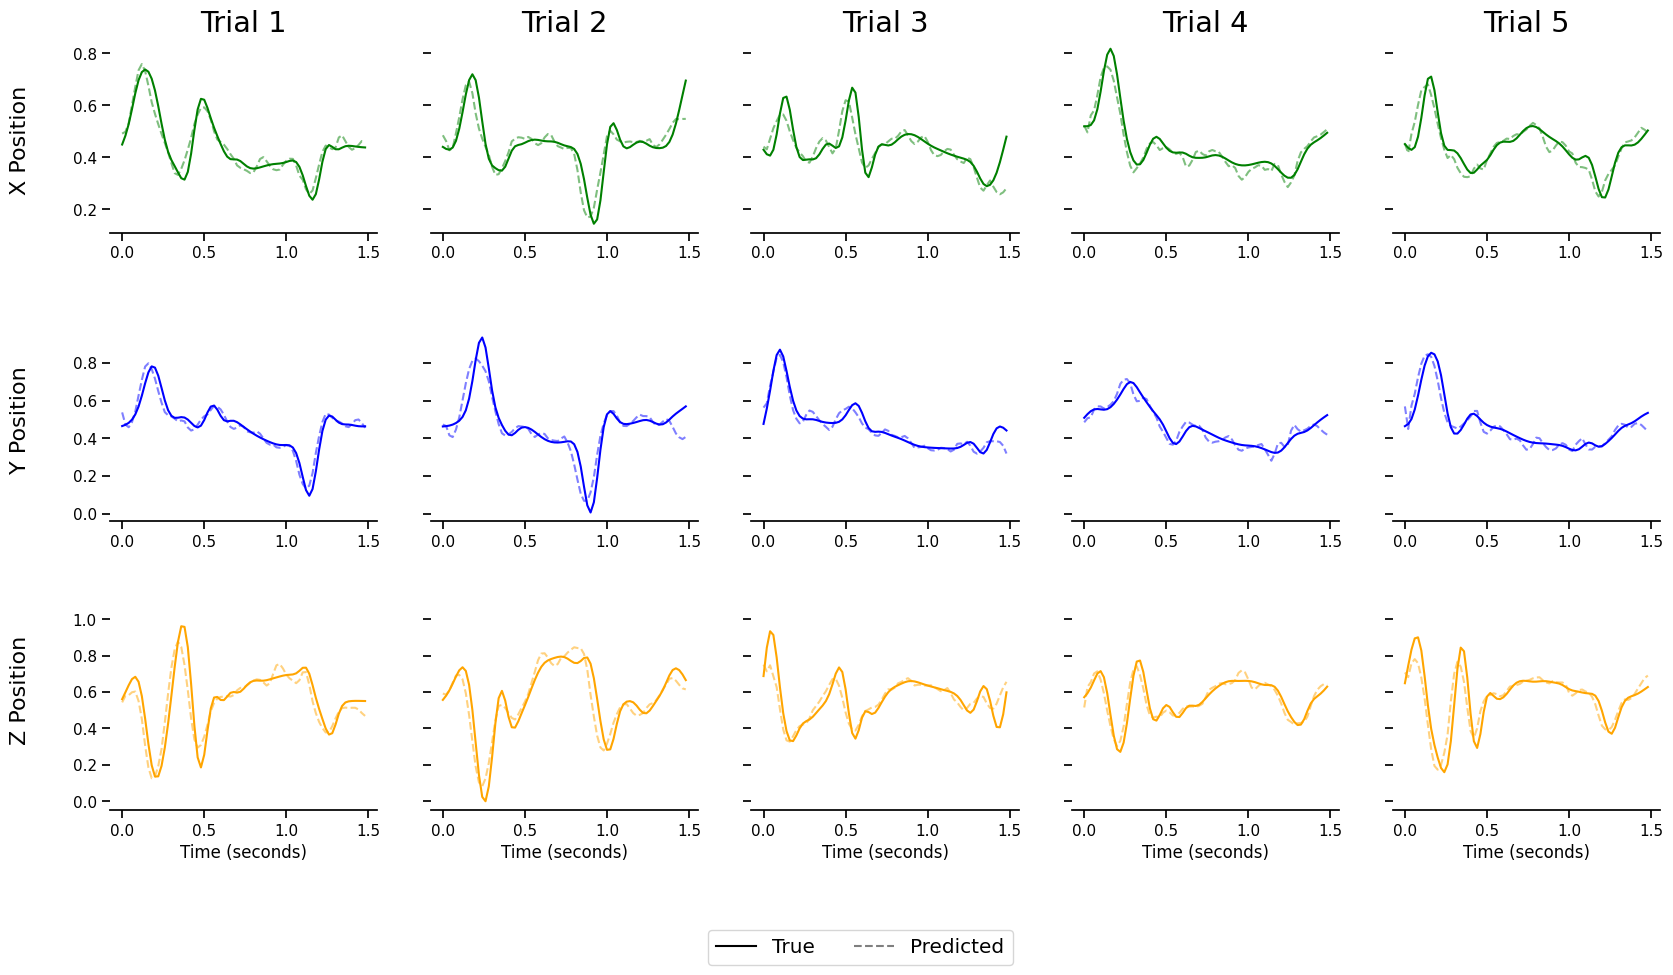

In [ ]:
visualize_LSTM_test(y_pred_train, y_true_train, seq_length = 75)

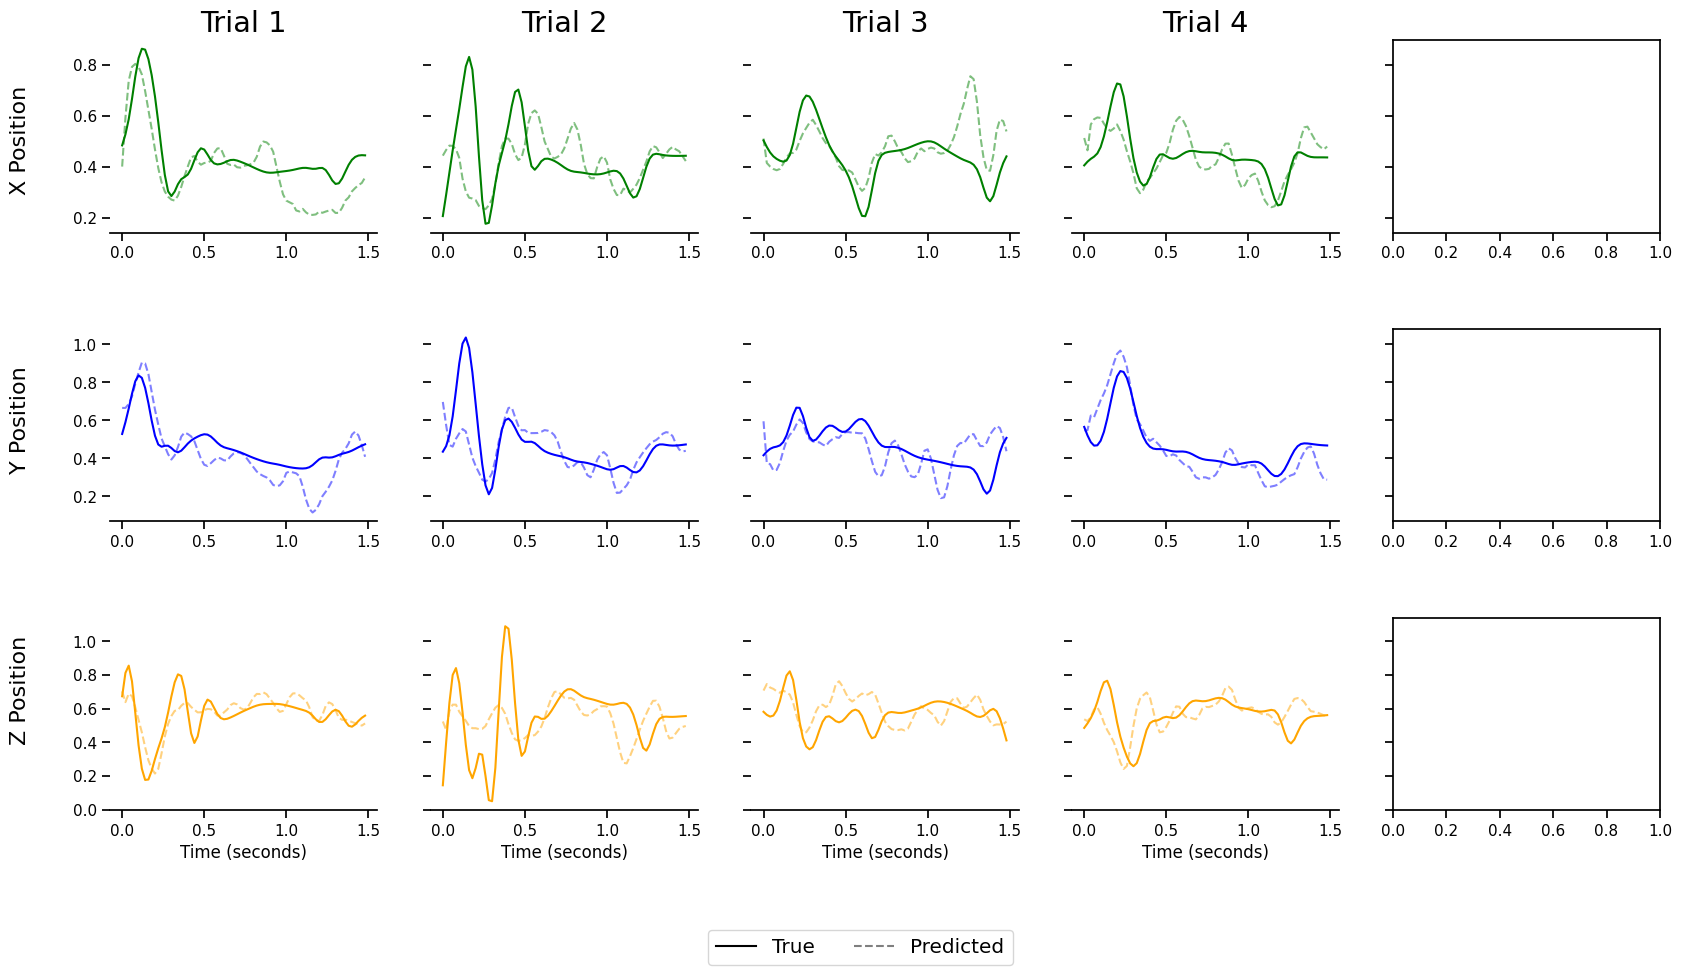

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [31]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base, metric = 'ev')

Train EV: 0.04 
Val EV: 0.13 
Test EV: 0.00 


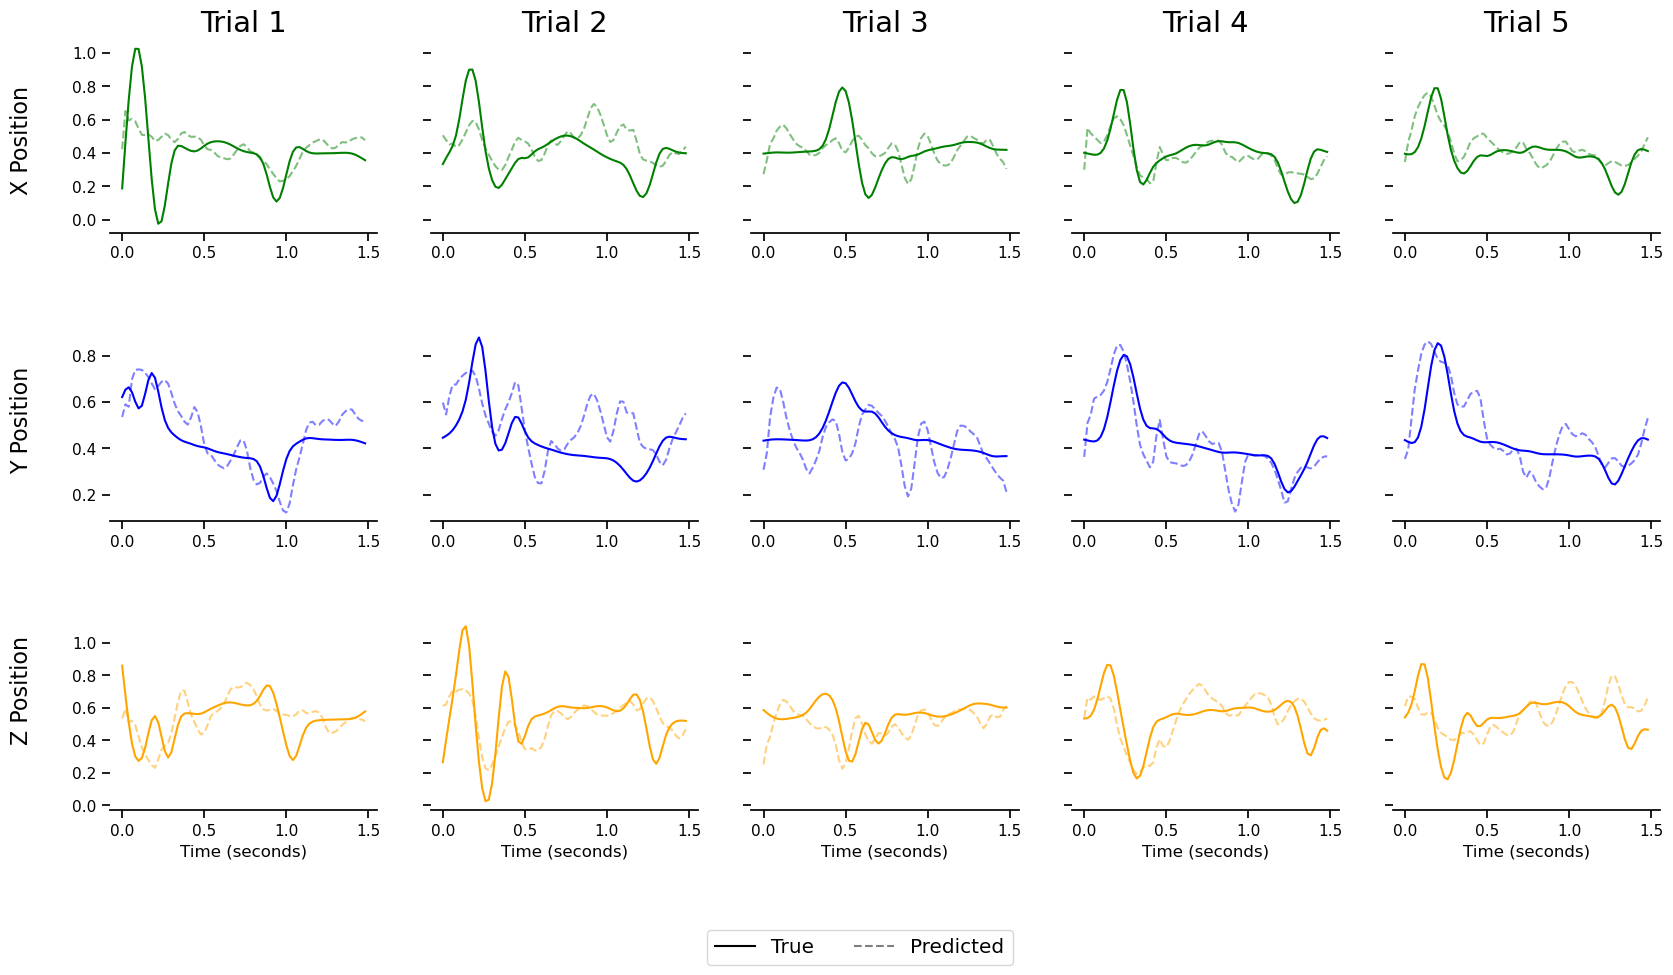

In [32]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [33]:
# Fit the LSTM model
model_all = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                input_size = input_size_LSTM,
                out_dims = num_dim_output).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_all.apply(weight_reset)

Model(
  (rnn): RNN(128, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)

In [34]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0559 Val 0.0182
Epoch 001 Train 0.0135 Val 0.0104
Epoch 002 Train 0.0088 Val 0.0073
Epoch 003 Train 0.0064 Val 0.0056
Epoch 004 Train 0.0051 Val 0.0046
Epoch 005 Train 0.0042 Val 0.0040
Epoch 006 Train 0.0037 Val 0.0036
Epoch 007 Train 0.0033 Val 0.0034
Epoch 008 Train 0.0031 Val 0.0032
Epoch 009 Train 0.0028 Val 0.0031
Epoch 010 Train 0.0027 Val 0.0030
Epoch 011 Train 0.0025 Val 0.0029
Epoch 012 Train 0.0024 Val 0.0030
Epoch 013 Train 0.0023 Val 0.0028
Epoch 014 Train 0.0022 Val 0.0028
Epoch 015 Train 0.0021 Val 0.0028
Epoch 016 Train 0.0020 Val 0.0028
Epoch 017 Train 0.0020 Val 0.0027
Epoch 018 Train 0.0019 Val 0.0027
Epoch 019 Train 0.0018 Val 0.0027
Epoch 020 Train 0.0017 Val 0.0027
Epoch 021 Train 0.0017 Val 0.0028
Epoch 022 Train 0.0016 Val 0.0028
Decrease LR
Epoch 023 Train 0.0016 Val 0.0027
Epoch 024 Train 0.0015 Val 0.0028
Epoch 025 Train 0.0015 Val 0.0028
Epoch 026 Train 0.0015 Val 0.0028
Epoch 027 Train 0.0014 Val 0.0028
Decrease LR
18


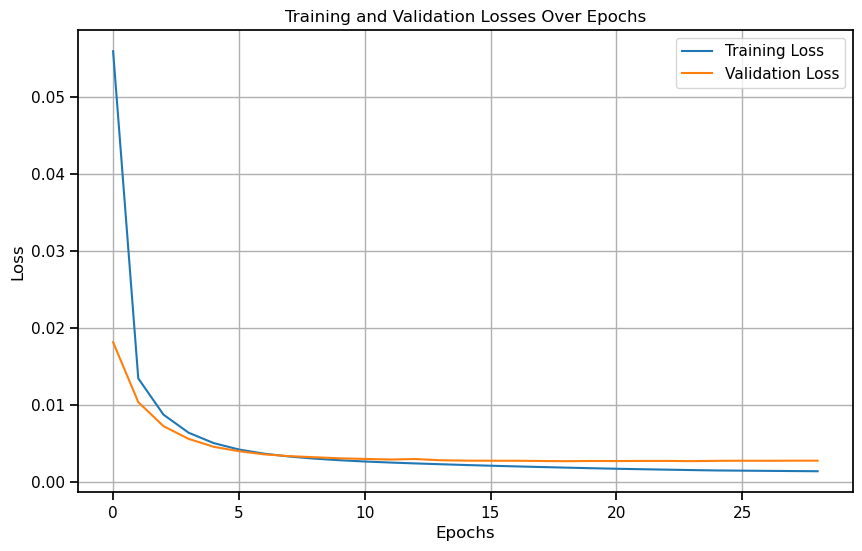

In [35]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [36]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Alldata'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_all, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Alldata'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_all, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [37]:
""" model_all_data = torch.load(path_to_save_model_fold)
model_all_data.eval() """

' model_all_data = torch.load(path_to_save_model_fold)\nmodel_all_data.eval() '

In [38]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all, metric = 'ev')

Train EV: 0.63 
Val EV: 0.45 
Test EV: 0.00 


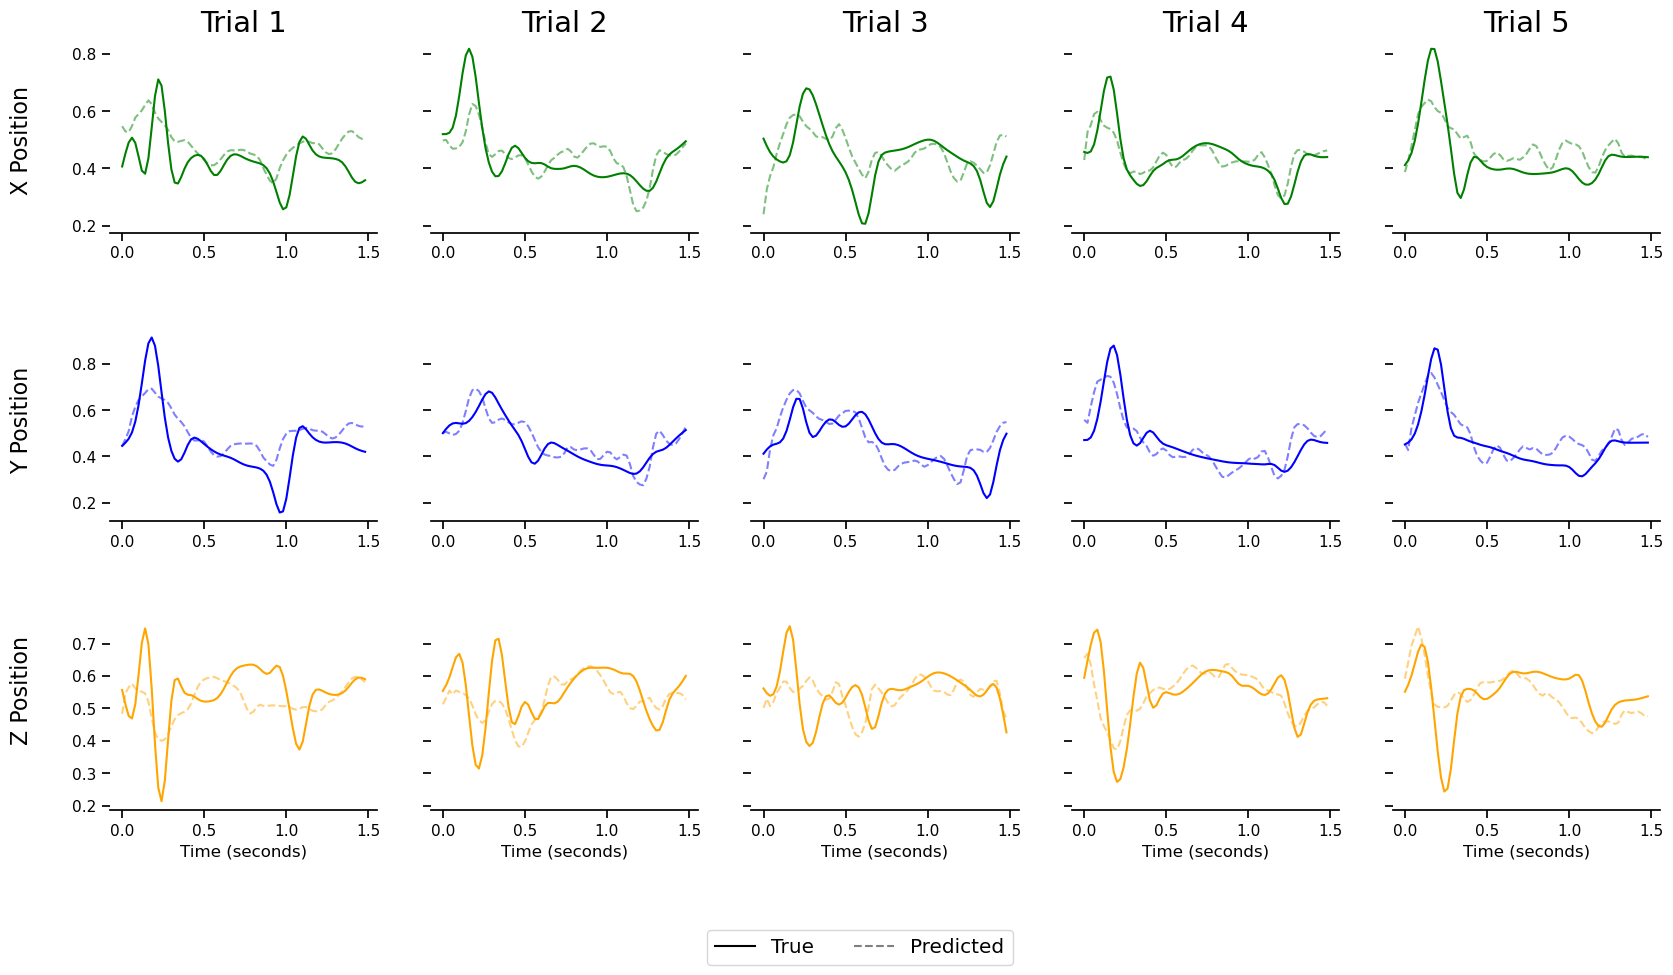

In [39]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [40]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [41]:
x = to_t_eval(xx_train_base) 
y = to_t_eval(yy_train_base)

In [42]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [43]:
""" experiment_name_base = 'LSTM_2018'+date+'_Baseline'
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold)) """


" experiment_name_base = 'LSTM_2018'+date+'_Baseline'\npath_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold)) "

In [44]:
import copy

In [45]:
model_baselineonly = copy.deepcopy(model_base)
# Flatten the parameters of the copied model
for module in model_baselineonly.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()
model_baselineonly.train()

Model(
  (rnn): RNN(128, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)

In [46]:
params = {n: p for n, p in model_baselineonly.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [47]:
def get_fisher_diag(model, dataset, params, empirical=True):
 
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        model.train()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [48]:
fisher_matrix = get_fisher_diag(model_baselineonly, dataset, params)

In [49]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=lr, # 0.0001,
                lr_step_size= lr_step_size ,#10,
                lr_gamma=lr_gamma,#0.9,
                sequence_length_LSTM= seq_length_LSTM, #10,
                batch_size_train = batch_size_train, #3,
                batch_size_val = batch_size_val,# 3,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None,
                l1_ratio = l1_ratio_reg, #0.5,
                alpha = alpha_reg, #1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                X_ = X_.to(device)
                y_ = y_.to(device)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [50]:
train_losses, val_losses = \
    train_model_EWC(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= True,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.8
                )


Epoch 000 Train 0.0084 Val 0.0077
Epoch 001 Train 0.0066 Val 0.0071
Epoch 002 Train 0.0057 Val 0.0068
Epoch 003 Train 0.0051 Val 0.0065
Epoch 004 Train 0.0047 Val 0.0065
Epoch 005 Train 0.0043 Val 0.0063
Epoch 006 Train 0.0040 Val 0.0063
Epoch 007 Train 0.0037 Val 0.0062
Epoch 008 Train 0.0035 Val 0.0063
Epoch 009 Train 0.0033 Val 0.0063
Epoch 010 Train 0.0031 Val 0.0063
Epoch 011 Train 0.0029 Val 0.0064
Epoch 012 Train 0.0027 Val 0.0066
Epoch 013 Train 0.0026 Val 0.0066
Epoch 014 Train 0.0025 Val 0.0066
Decrease LR
Epoch 015 Train 0.0023 Val 0.0067
Epoch 016 Train 0.0022 Val 0.0068
Epoch 017 Train 0.0022 Val 0.0068
Epoch 018 Train 0.0021 Val 0.0069
Epoch 019 Train 0.0021 Val 0.0069
Decrease LR


In [51]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_EWC'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_baselineonly, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [52]:
""" model_EWC = torch.load(path_to_save_model_fold)
model_EWC.eval() """

' model_EWC = torch.load(path_to_save_model_fold)\nmodel_EWC.eval() '

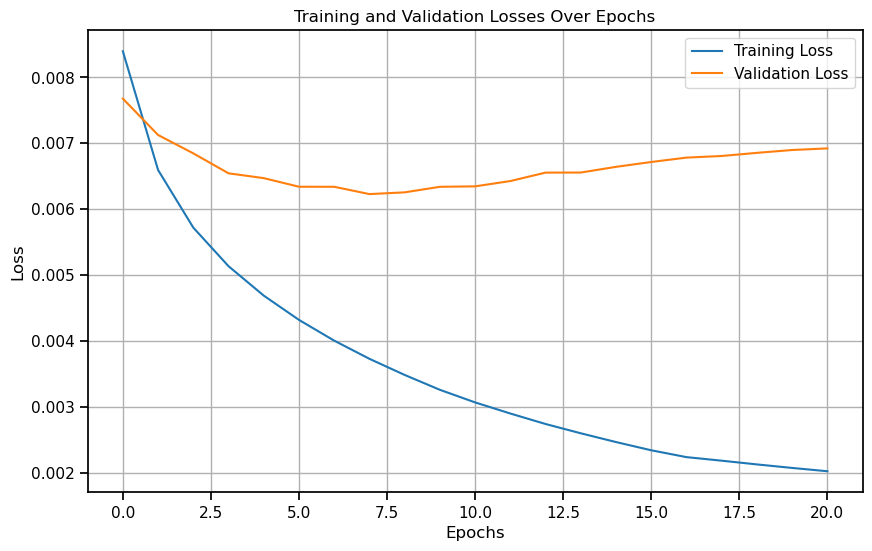

In [53]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [54]:
model_EWC = copy.deepcopy(model_baselineonly)

# Flatten the parameters of the copied model
for module in model_EWC.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [55]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_EWC, metric = 'ev')

Train EV: 0.63 
Val EV: 0.42 
Test EV: 0.00 


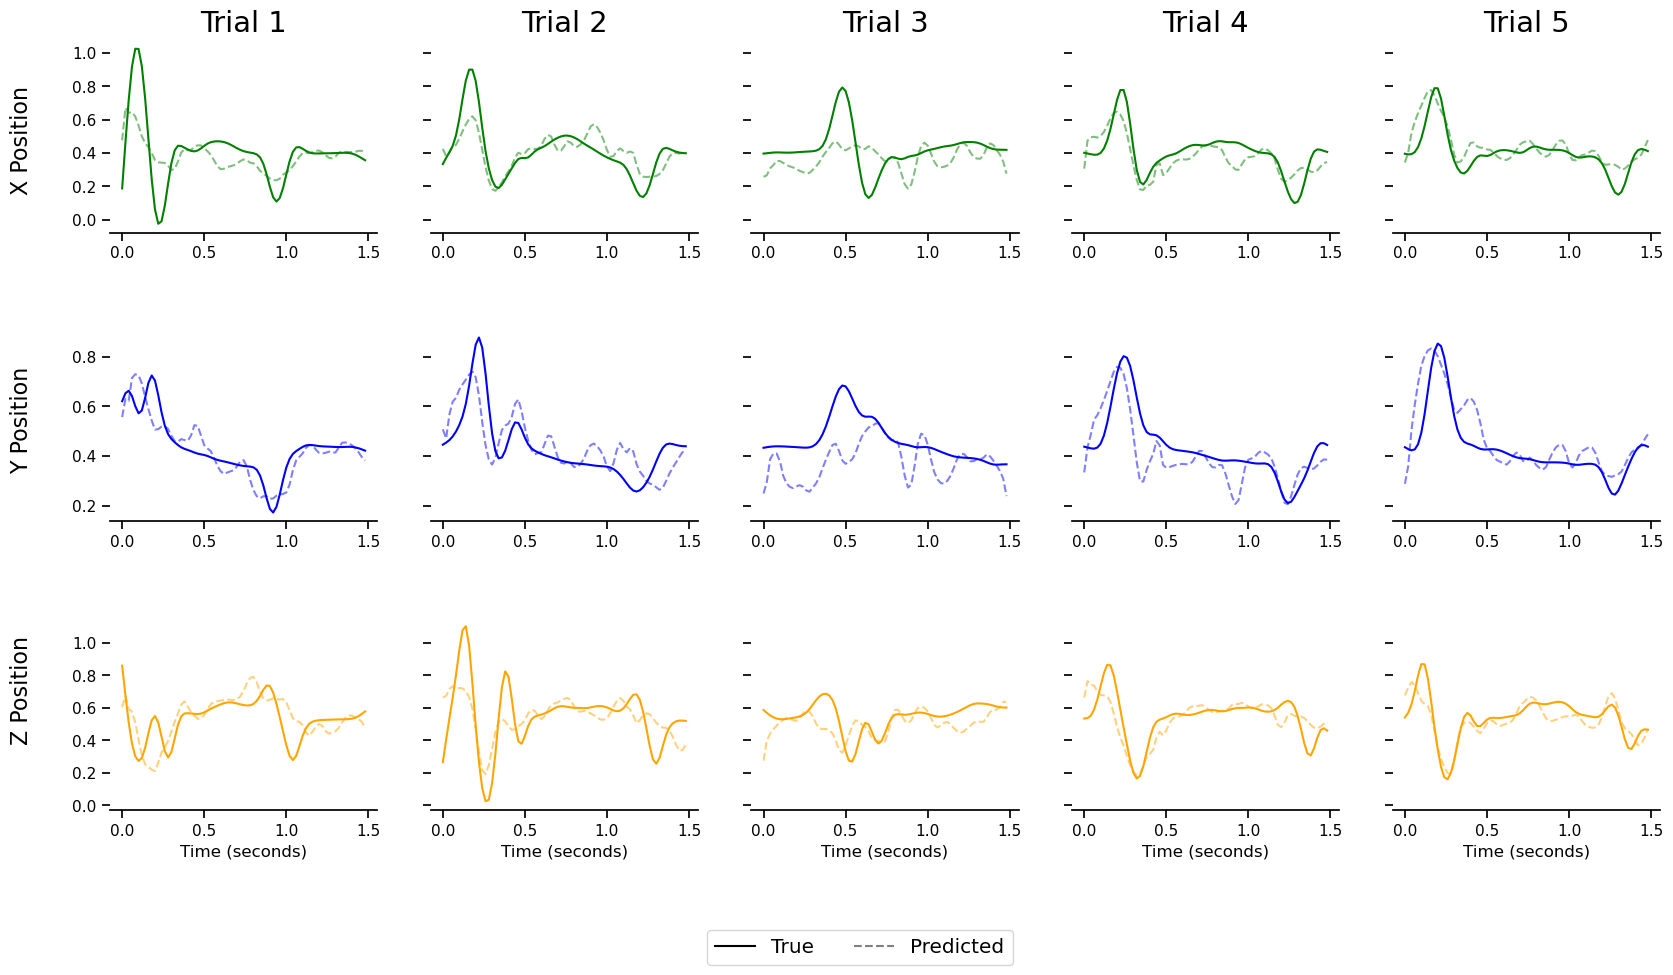

In [56]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Testing the performance of the model on Baseline data after EWC

In [57]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_EWC, metric = 'ev')

Train EV: 0.47 
Val EV: 0.17 
Test EV: 0.00 


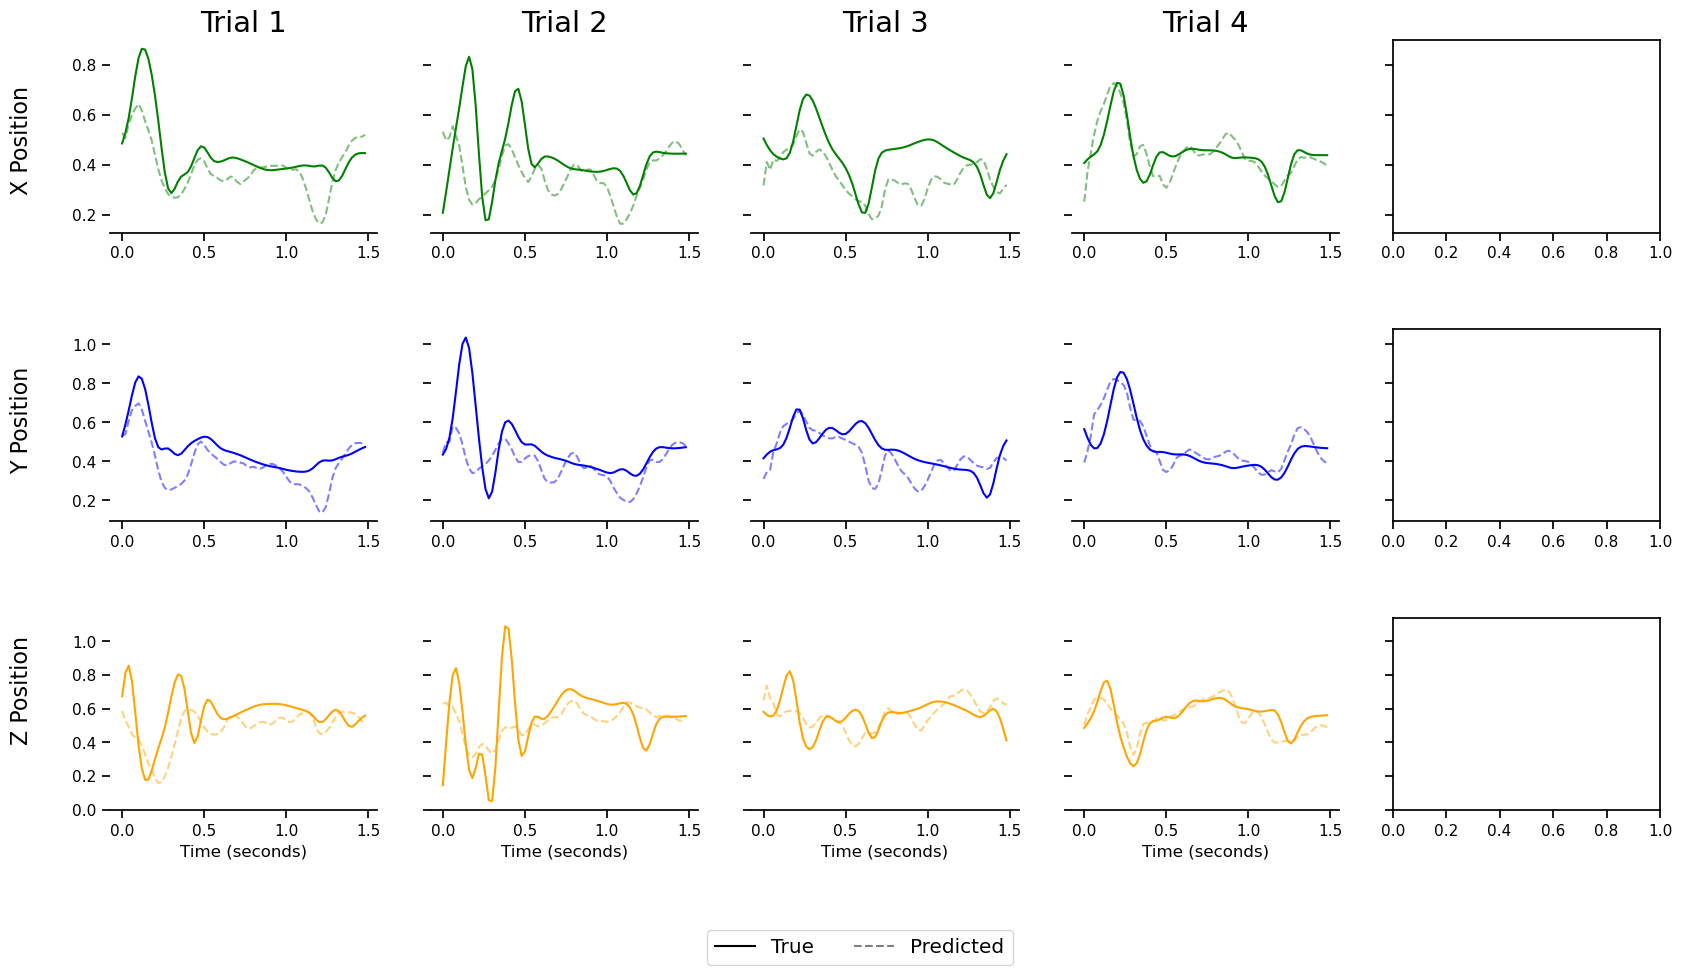

In [58]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [59]:
# Fit the LSTM model
model_stim = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                input_size = input_size_LSTM,
                out_dims = num_dim_output).to(device)

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_stim.apply(weight_reset)

Model(
  (rnn): RNN(128, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)

In [60]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.1383 Val 0.0936
Epoch 001 Train 0.0894 Val 0.0619
Epoch 002 Train 0.0574 Val 0.0409
Epoch 003 Train 0.0351 Val 0.0289
Epoch 004 Train 0.0236 Val 0.0240
Epoch 005 Train 0.0190 Val 0.0213
Epoch 006 Train 0.0165 Val 0.0192
Epoch 007 Train 0.0148 Val 0.0175
Epoch 008 Train 0.0134 Val 0.0161
Epoch 009 Train 0.0122 Val 0.0150
Epoch 010 Train 0.0113 Val 0.0141
Epoch 011 Train 0.0105 Val 0.0133
Epoch 012 Train 0.0098 Val 0.0126
Epoch 013 Train 0.0092 Val 0.0120
Epoch 014 Train 0.0087 Val 0.0115
Epoch 015 Train 0.0082 Val 0.0110
Epoch 016 Train 0.0077 Val 0.0106
Epoch 017 Train 0.0073 Val 0.0102
Epoch 018 Train 0.0070 Val 0.0099
Epoch 019 Train 0.0066 Val 0.0096
Epoch 020 Train 0.0063 Val 0.0093
Epoch 021 Train 0.0060 Val 0.0091
Epoch 022 Train 0.0058 Val 0.0089
Epoch 023 Train 0.0056 Val 0.0087
Epoch 024 Train 0.0053 Val 0.0086
Epoch 025 Train 0.0051 Val 0.0084
Epoch 026 Train 0.0049 Val 0.0083
Epoch 027 Train 0.0048 Val 0.0082
Epoch 028 Train 0.0046 Val 0.0081
Epoch 029 Trai

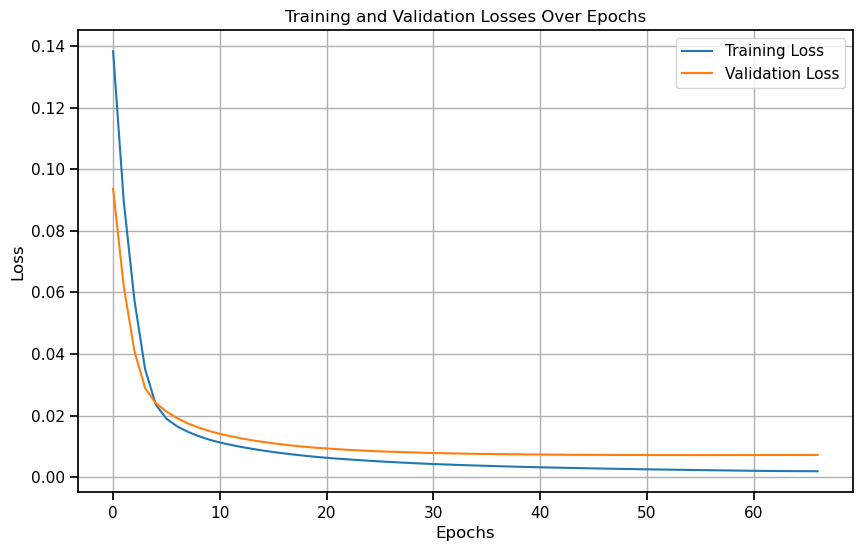

In [61]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [62]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """


" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Stimulation'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_stim, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [63]:
""" model_stim = torch.load(path_to_save_model_fold)
model_stim.eval() """

' model_stim = torch.load(path_to_save_model_fold)\nmodel_stim.eval() '

In [64]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim, metric = 'ev')

Train EV: 0.74 
Val EV: 0.28 
Test EV: 0.00 


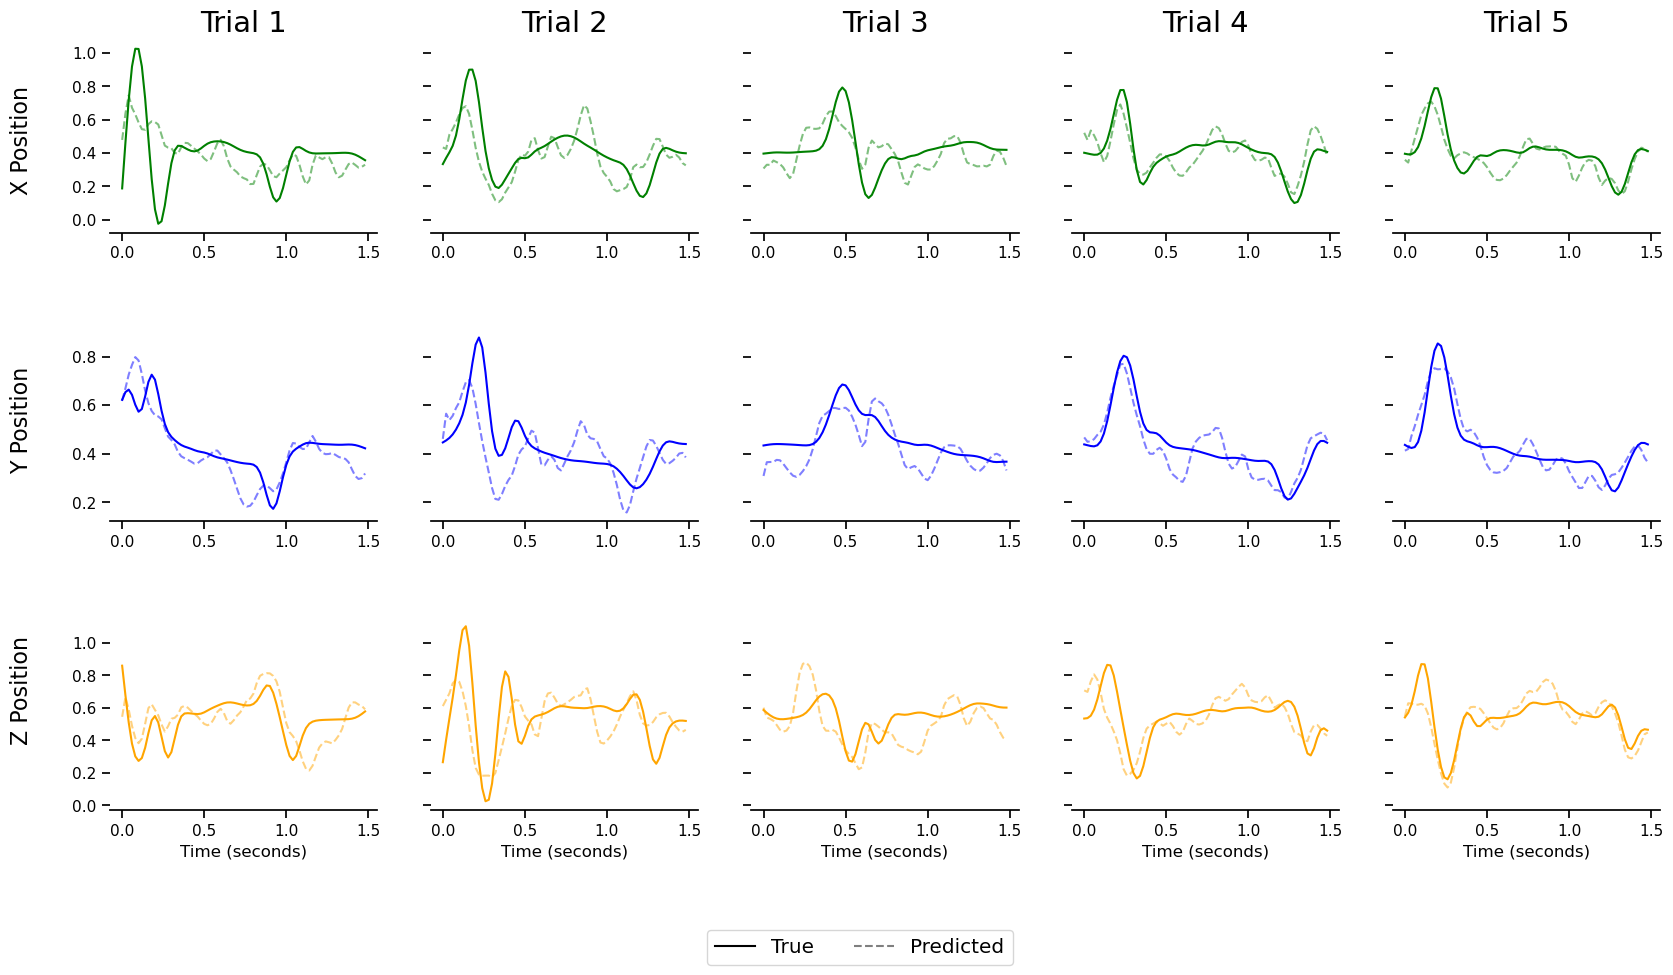

In [65]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Now test on baseline data to compare to the EWC

In [66]:
model_stim.eval()

Model(
  (rnn): RNN(128, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)

In [67]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim, metric = 'ev')

Train EV: -0.07 
Val EV: -0.07 
Test EV: 0.00 


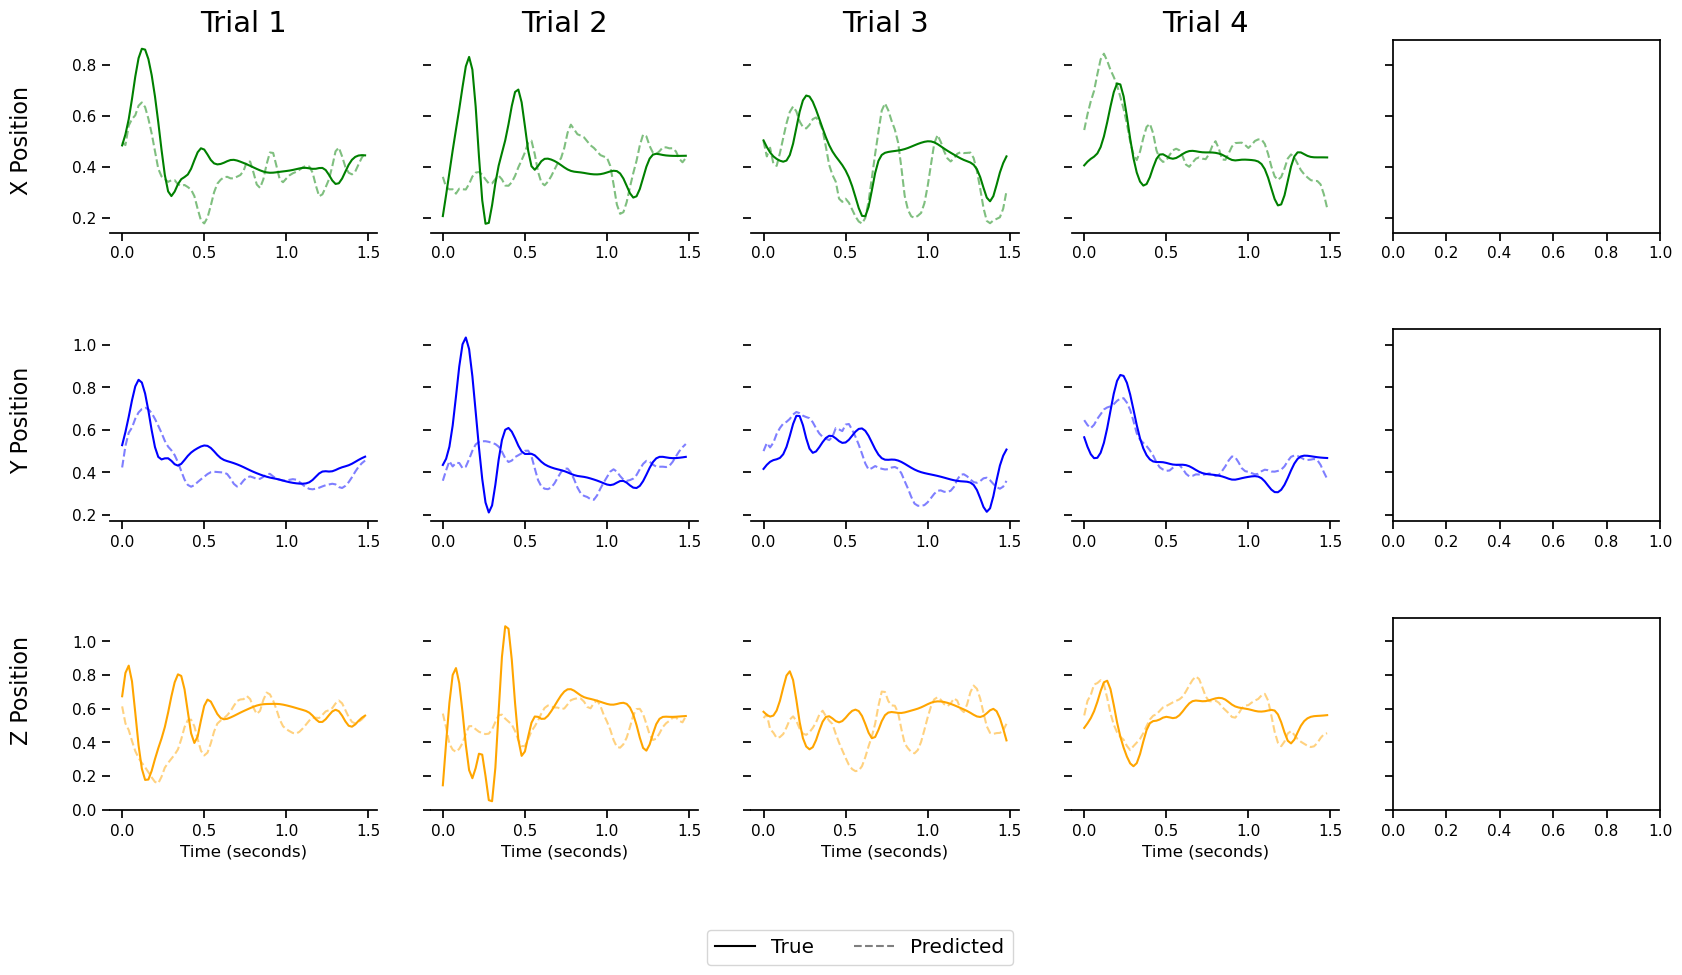

In [68]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Checking Catastrophic Forgetting

The idea here is to take models trained for one specific task, train them on the other task and then see how they generalize or not.

In [69]:
path_to_models = './Models'


In [70]:
""" experiment_name_base = 'LSTM_2018'+date+'_Baseline'
experiment_name_stim= 'LSTM_2018'+date+'_Stimulation' """

" experiment_name_base = 'LSTM_2018'+date+'_Baseline'\nexperiment_name_stim= 'LSTM_2018'+date+'_Stimulation' "

In [71]:
""" path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))
path_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold)) """

" path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))\npath_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold)) "

In [72]:
""" model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train() """

' model_baselineonly = torch.load(path_model_baseline)\nmodel_baselineonly.train() '

In [73]:
""" model_stimonly = torch.load(path_model_stim)
model_stimonly.train() """

' model_stimonly = torch.load(path_model_stim)\nmodel_stimonly.train() '

#### Training on stimulation data using baseline model

In [74]:
model_stim_after_base  = copy.deepcopy(model_base)

# Flatten the parameters of the copied model
for module in model_stim_after_base.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [75]:
train_losses, val_losses = \
    train_model(model_stim_after_base, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0083 Val 0.0076
Epoch 001 Train 0.0065 Val 0.0071
Epoch 002 Train 0.0057 Val 0.0068
Epoch 003 Train 0.0051 Val 0.0065
Epoch 004 Train 0.0047 Val 0.0064
Epoch 005 Train 0.0043 Val 0.0064
Epoch 006 Train 0.0040 Val 0.0063
Epoch 007 Train 0.0037 Val 0.0063
Epoch 008 Train 0.0035 Val 0.0063
Epoch 009 Train 0.0032 Val 0.0064
Epoch 010 Train 0.0030 Val 0.0063
Epoch 011 Train 0.0029 Val 0.0064
Epoch 012 Train 0.0027 Val 0.0065
Epoch 013 Train 0.0026 Val 0.0065
Epoch 014 Train 0.0024 Val 0.0066
Decrease LR
Epoch 015 Train 0.0023 Val 0.0067
Epoch 016 Train 0.0022 Val 0.0068
Epoch 017 Train 0.0022 Val 0.0068
Epoch 018 Train 0.0021 Val 0.0069
Epoch 019 Train 0.0021 Val 0.0070
Decrease LR
8


In [76]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_baselineonly, path_to_save_model_fold) "

In [77]:
""" model_stim_after_base = torch.load(path_to_save_model_fold)
model_stim_after_base.eval() """

' model_stim_after_base = torch.load(path_to_save_model_fold)\nmodel_stim_after_base.eval() '

In [78]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_after_base, metric = 'ev')

Train EV: 0.46 
Val EV: 0.16 
Test EV: 0.00 


In [79]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_after_base, metric = 'ev')

Train EV: 0.65 
Val EV: 0.41 
Test EV: 0.00 


#### Training on baseline data using stimulation model

In [80]:
model_base_after_stim = copy.deepcopy(model_stim)

# Flatten the parameters of the copied model
for module in model_base_after_stim.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [81]:
train_losses, val_losses = \
    train_model(model_base_after_stim, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0071 Val 0.0083
Epoch 001 Train 0.0056 Val 0.0080
Epoch 002 Train 0.0050 Val 0.0078
Epoch 003 Train 0.0046 Val 0.0077
Epoch 004 Train 0.0042 Val 0.0076
Epoch 005 Train 0.0040 Val 0.0075
Epoch 006 Train 0.0037 Val 0.0075
Epoch 007 Train 0.0035 Val 0.0075
Epoch 008 Train 0.0033 Val 0.0075
Epoch 009 Train 0.0032 Val 0.0074
Epoch 010 Train 0.0030 Val 0.0075
Epoch 011 Train 0.0029 Val 0.0075
Epoch 012 Train 0.0028 Val 0.0074
Epoch 013 Train 0.0026 Val 0.0074
Epoch 014 Train 0.0025 Val 0.0075
Epoch 015 Train 0.0024 Val 0.0075
Epoch 016 Train 0.0023 Val 0.0075
Decrease LR
Epoch 017 Train 0.0022 Val 0.0075
Epoch 018 Train 0.0022 Val 0.0076
Epoch 019 Train 0.0021 Val 0.0076
Epoch 020 Train 0.0021 Val 0.0076
Epoch 021 Train 0.0020 Val 0.0076
Decrease LR
12


In [82]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stimonly, path_to_save_model_fold) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_stimonly, path_to_save_model_fold) "

In [83]:
""" model_base_after_stim = torch.load(path_to_save_model_fold)
model_base_after_stim.eval() """

' model_base_after_stim = torch.load(path_to_save_model_fold)\nmodel_base_after_stim.eval() '

In [84]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base_after_stim, metric = 'ev')

Train EV: 0.59 
Val EV: 0.38 
Test EV: 0.00 


In [85]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base_after_stim, metric = 'ev')

Train EV: 0.61 
Val EV: 0.22 
Test EV: 0.00 
